In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import config
import sklearn
from sklearn import metrics
from tqdm import tqdm
import config
import designimg as d

In [27]:
oof_path = f'/home/asajw/SETI/output/efficientnet_b0_dt0605/oof_df_efficientnet_b0_bs32_size256_dt0605.csv'

In [96]:
oof = pd.read_csv(oof_path)
oof.head()

predictions  targets  target_ids
0     0.003006      0.0       28093
1     0.028116      0.0       36847
2     0.001509      0.0       46850
3     0.000291      0.0       45410
4     0.003727      0.0        9789

In [29]:
oof.targets.value_counts()

0.0    45471
1.0     4694
Name: targets, dtype: int64

In [30]:
# defining tp, tn, fp, fn from basic

class Metrics():
    def __init__(self, ytrue, ypred):
        self.ytrue = ytrue
        self.ypred = ypred
        
    def true_pos(self):
        tp = 0
        for yt, yp in zip(self.ytrue, self.ypred):
            if yt == 1 and yp == 1:
                tp += 1
        return tp

    def true_neg(self):
        tn = 0
        for yt, yp in zip(self.ytrue, self.ypred):
            if yt == 0 and yp == 0:
                tn += 1
        return tn

    def false_pos(self):
        fp = 0
        for yt, yp in zip(self.ytrue, self.ypred):
            if yt == 0 and yp == 1:
                fp += 1
        return fp

    def false_neg(self):
        fn = 0
        for yt, yp in zip(self.ytrue, self.ypred):
            if yt == 1 and yp == 0:
                fn += 1
        return fn

    def precision(self):
        tp = self.true_pos()
        fp = self.false_pos()
        return tp / (tp + fp)

    def recall(self):
        tp = self.true_pos()
        fn = self.false_neg()  
        return tp / (tp + fn)
    
    def f1(self):
        p = self.precision()
        r = self.recall()
        return 2*p*r / (p +r)
    
    def tpr(self):
        return self.recall()
    
    def fpr(self):
        fp = self.false_pos()
        tn = self.true_neg()
        return fp / (fp + tn)
    
    def roc_auc(self):
        return metrics.roc_auc_score(self.ytrue, self.ypred)
    
    

In [31]:
thresholds = [x/1000 for x in range(1000)]

In [32]:
mDF = pd.DataFrame({
                    'threshold':[],
                    'fp':[], 'fn':[], 'tn':[], 'tp':[],
                    'precision':[], 'recall':[],
                    'tpr':[], 'fpr':[],
                    'f1':[], 'roc_threshold':[],
                    })


In [33]:
for i, threshold in tqdm(enumerate(thresholds)):
    ypred = oof['predictions'].values.tolist()
    ypred = [1 if y > threshold else 0 for y in ypred]
    ytrue = oof['targets'].values.tolist()
    m = Metrics(ytrue, ypred)
    mDF.loc[i, 'threshold'] = threshold
    mDF.loc[i, 'fp'] = m.false_pos()
    mDF.loc[i,'fn'] = m.false_neg()
    mDF.loc[i,'tp'] = m.true_pos()
    mDF.loc[i,'tn'] = m.true_neg()
    mDF.loc[i,'precision'] = m.precision()
    mDF.loc[i,'recall'] = m.recall()
    mDF.loc[i,'tpr'] = m.tpr()
    mDF.loc[i,'fpr'] = m.fpr()
    mDF.loc[i,'f1'] = m.f1()
    mDF.loc[i,'roc_threshold'] = m.roc_auc()

1000it [01:11, 13.94it/s]


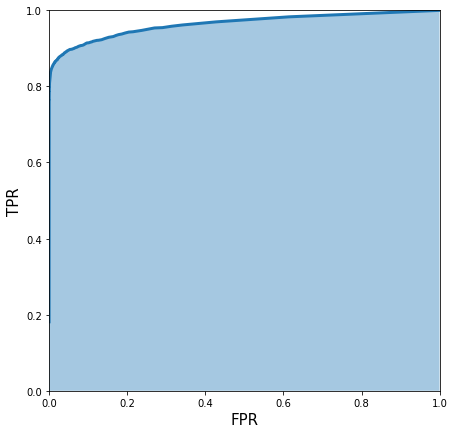

In [34]:
plt.figure(figsize=(7,7))
plt.fill_between(mDF['fpr'].values.tolist(), mDF['tpr'].values.tolist(), alpha = 0.4)
plt.plot(mDF['fpr'].values.tolist(), mDF['tpr'].values.tolist(), lw = 3)
plt.xlim(0, 1.0)
plt.ylim(0, 1.0)
plt.xlabel('FPR', fontsize = 15)
plt.ylabel('TPR', fontsize = 15)
plt.show()

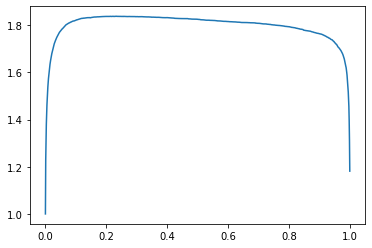

In [35]:
mDF['sweet_spot'] = (mDF['tpr']+1)/( mDF['fpr'] + 1)
plt.plot(mDF['threshold'], mDF['sweet_spot'])
plt.show()

In [36]:
mDF.query('threshold >0.8 and threshold < 0.86').head()

threshold    fp     fn       tn      tp  precision    recall       tpr  \
801      0.801  34.0  964.0  45437.0  3730.0   0.990967  0.794631  0.794631   
802      0.802  34.0  966.0  45437.0  3728.0   0.990962  0.794205  0.794205   
803      0.803  32.0  968.0  45439.0  3726.0   0.991485  0.793779  0.793779   
804      0.804  32.0  968.0  45439.0  3726.0   0.991485  0.793779  0.793779   
805      0.805  32.0  970.0  45439.0  3724.0   0.991480  0.793353  0.793353   

          fpr        f1  roc_threshold  sweet_spot  
801  0.000748  0.882005       0.896942    1.793291  
802  0.000748  0.881741       0.896729    1.792865  
803  0.000704  0.881685       0.896538    1.792518  
804  0.000704  0.881685       0.896538    1.792518  
805  0.000704  0.881420       0.896325    1.792092

In [43]:
threshold_fp = 0.82 #to identify the real fp set it high
oof['predictions_bool_fp'] = oof['predictions'].apply(lambda x : 0 if x < threshold_fp else 1)  
oof['fp'] = oof.apply(lambda x: Metrics([x['targets']],
                                        [x['predictions_bool_fp']]).false_pos(), axis = 1) 
threshold_fn = 0.20 # to identify the real fn set it low
oof['predictions_bool_fn'] = oof['predictions'].apply(lambda x : 0 if x < threshold_fn else 1)  
oof['fn'] = oof.apply(lambda x: Metrics([x['targets']],
                                        [x['predictions_bool_fn']]).false_neg(), axis = 1)

In [44]:
oof.query('fp == 1').head()

predictions  targets  target_ids  predictions_bool_fp  fp  \
395      0.888860      0.0       37505                    1   1   
1264     0.990097      0.0        4185                    1   1   
4551     0.823708      0.0       23358                    1   1   
7256     0.991508      0.0         462                    1   1   
7573     0.909573      0.0       48810                    1   1   

      predictions_bool_fn  fn  
395                     1   0  
1264                    1   0  
4551                    1   0  
7256                    1   0  
7573                    1   0

In [45]:
tr = pd.read_csv(f'{config.DATA_PATH}train_labels.csv')
trfp = tr[tr.index.isin(oof.query('fp == 1')['target_ids'].values.tolist())]
trfn = tr[tr.index.isin(oof.query('fn == 1')['target_ids'].values.tolist())]

In [46]:
# negative images classified as positive (fp)
print(trfp.head(), '\n\n', trfn.head())

                id  target
165   00db570b18df       0
462   028148172c69       0
1132  05c47a7ada9f       0
4185  150be16760e4       0
5470  1ba80569438e       0 

                id  target
76   00667e94a985       1
85   0078157399c9       1
134  00b3a5364176       1
211  011184c5f640       1
394  0216000821a3       1


In [71]:
def disp_image(image_path):
    img = np.load(image_path)
    plt.imshow(img)
    plt.show()

00db570b18df


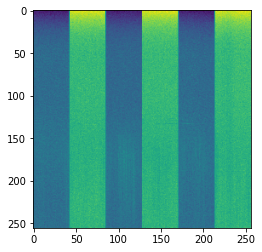

028148172c69


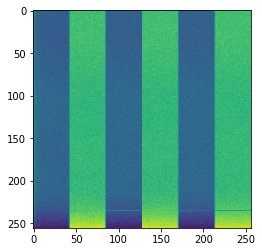

05c47a7ada9f


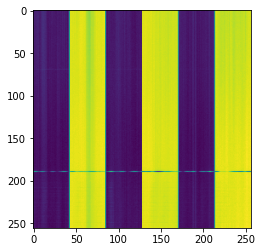

150be16760e4


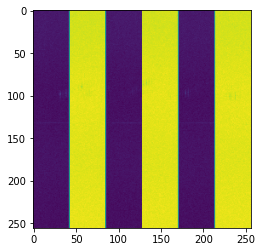

1ba80569438e


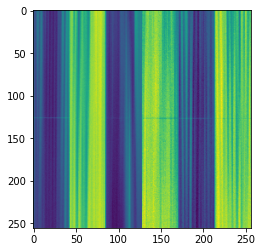

2147ed12282f


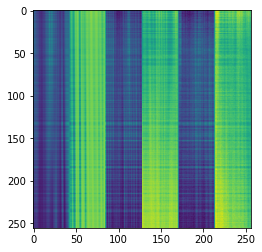

3919ab9605b1


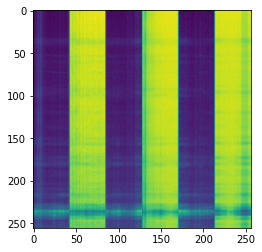

3aeba419cd4f


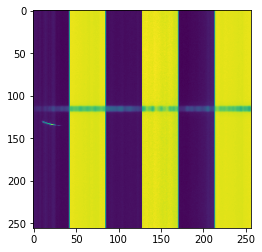

3d601f7599e5


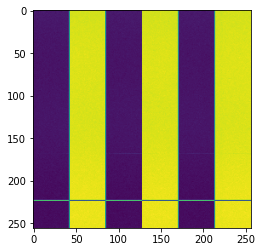

7680e60f1c39


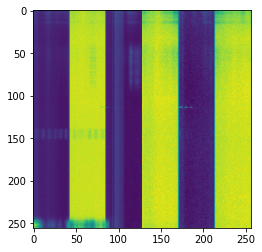

In [52]:
#images classified as positive but aren't
pos_imgs = trfp.id.values
for i in pos_imgs[0:10]:
    print(i)
    disp_image(f'{config.RESIZED_IMAGE_PATH}train/{i}.npy')

0 00667e94a985


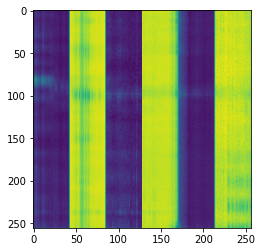

1 0078157399c9


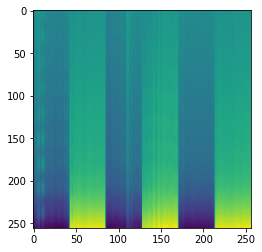

2 00b3a5364176


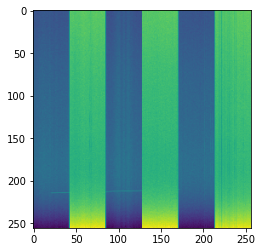

3 011184c5f640


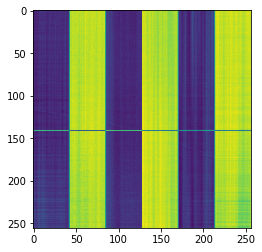

4 0216000821a3


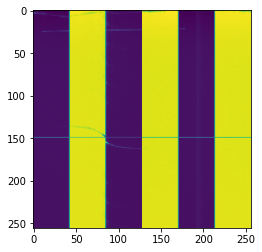

5 025a8396f9db


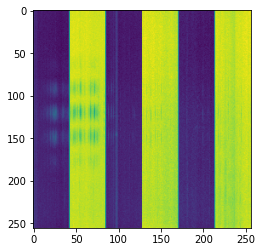

6 02616cd942c6


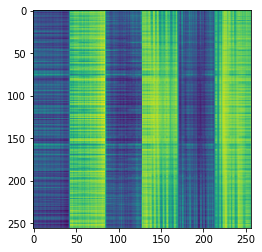

7 03012c5c944c


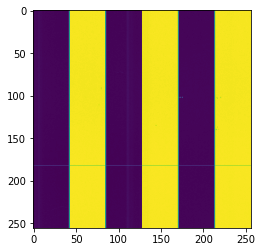

8 0386694b90cf


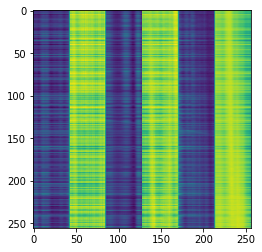

9 039c792fb361


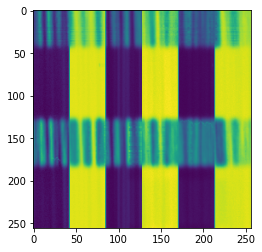

In [85]:
#images classified as negative but are positive 
pos_imgs = trfn.id.values
for i, img in enumerate(pos_imgs[0:10]):
    print(i, img)
    disp_image(f'{config.RESIZED_IMAGE_PATH}train/{img}.npy')

In [53]:
trl = pd.read_csv(f'{config.DATA_PATH}train_labels.csv')
trlp = trl[trl['target'] == 1]
trln = trl[trl['target'] == 0]
trln.query(f'''id == '1ba80569438e' ''')

id  target
5470  1ba80569438e       0

In [56]:
trl = pd.read_csv(f'{config.DATA_PATH}train_labels.csv')
trlp = trl[trl['target'] == 1]
trln = trl[trl['target'] == 0]
trlp.query(f'''id == '00667e94a985' ''')

id  target
76  00667e94a985       1

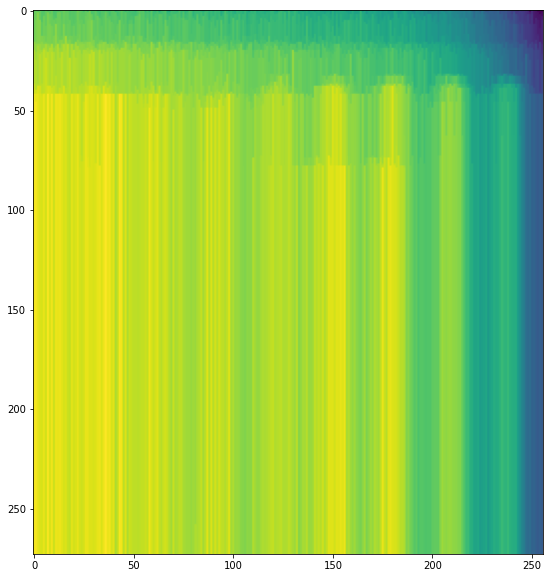

In [122]:
# trying to enhance needle
import cv2
i = '0078157399c9'
img = np.load(f'{config.DATA_PATH}train/{i[0]}/{i}.npy')[0]
kernel =np.ones((2,1), np.float32)
img_dilation = cv2.dilate(img.astype(float), kernel, iterations = 1000)
plt.figure(figsize = (16,10))
plt.imshow(img_dilation)
plt.show()

0078157399c9
0


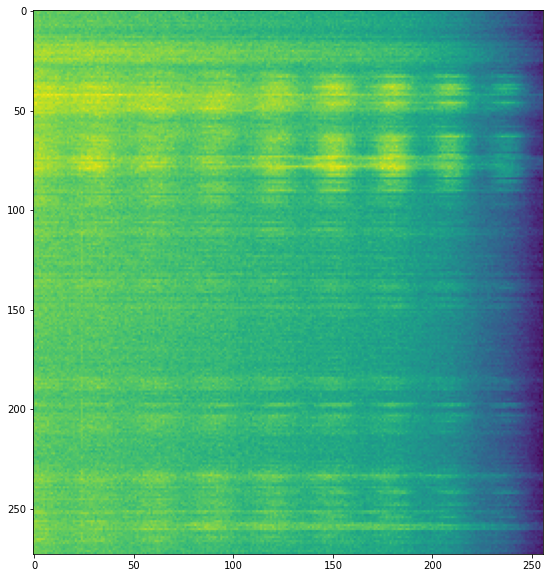

1


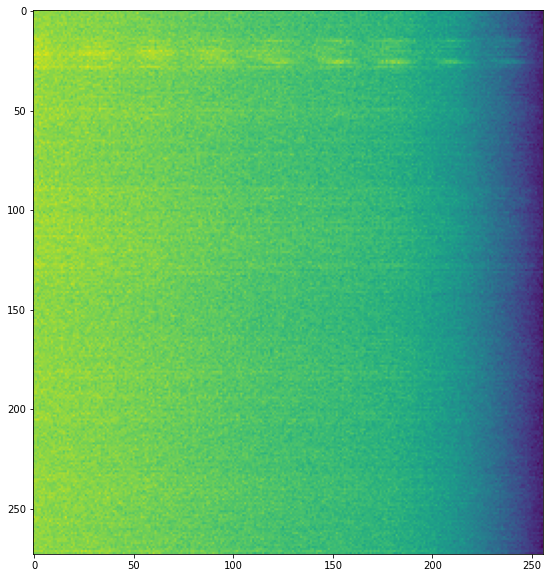

2


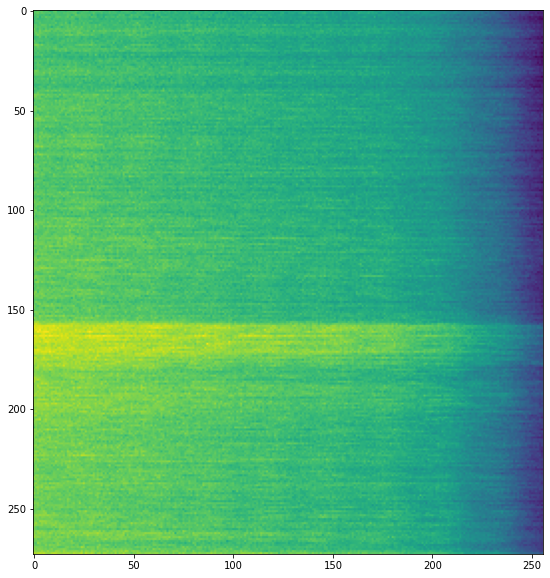

3


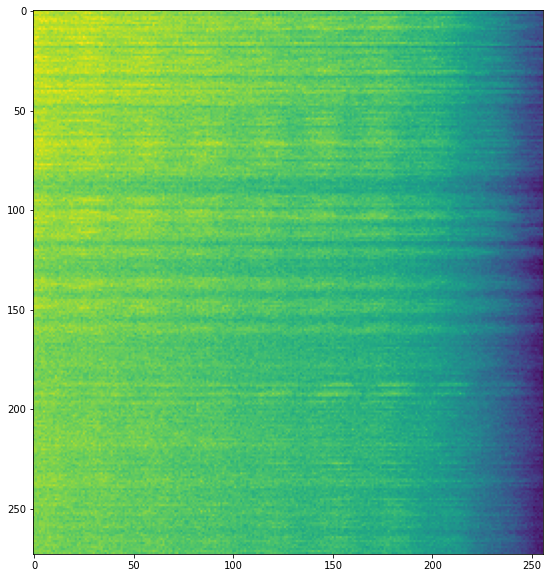

4


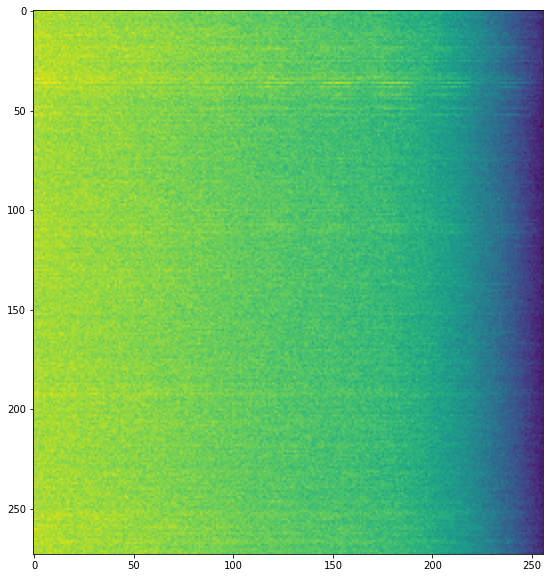

5


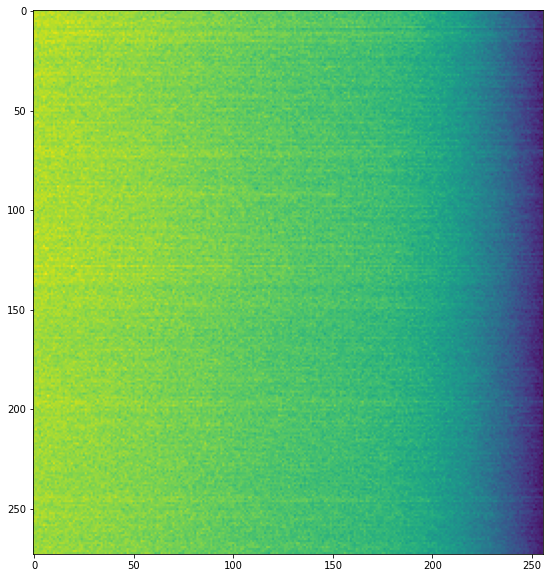

In [97]:
#display original image
def disp_origimage(image_path):
    img = np.load(image_path)
    for i in range(6):
        print(i)
        plt.figure(figsize = (16,10))
        plt.imshow(img[i].astype(float))
        plt.show()
# show fn in original size    
i = trfn.id.values[1]
print(i)
disp_origimage(f'{config.DATA_PATH}train/{i[0]}/{i}.npy')